# Topic models with Gensim

Gensim is a popular library for topic modeling. Here we'll see how it stacks up to scikit-learn.

<p class="reading-options">
  <a class="btn" href="/text-analysis/topic-models-with-gensim">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/text-analysis/notebooks/Topic models with Gensim.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/text-analysis/notebooks/Topic models with Gensim.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **recipes.csv:** recipes - a list of recipes (but only with ingredient names)
* **state-of-the-union.csv:** State of the Union addresses - each presidential address from 1970 to 2012


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv -P data

## Gensim vs. Scikit-learn

[Gensim](https://radimrehurek.com/gensim/) is a very very popular piece of software to do topic modeling with (as is [Mallet](http://mallet.cs.umass.edu/topics.php), if you're making a list). Since we're using scikit-learn for everything else, though, we use scikit-learn instead of Gensim when we get to topic modeling.

Since someone might show up one day offering us tens of thousands of dollars to demonstrate proficiency in Gensim, though, we might as well see how it works as compared to scikit-learn.

## Our data

We'll be using the same dataset as we did [with scikit-learn](/text-analysis/introduction-to-topic-modeling/#Attempt-two:-State-of-the-Union-addresses): State of the Union addresses from 1790 to 2012, where America's president addresses the Congress about the coming year.

In [83]:
import pandas as pd

df = pd.read_csv("data/state-of-the-union.csv")

# Clean it up a little bit, removing non-word characters (numbers and ___ etc)
df.content = df.content.str.replace("[^A-Za-z ]", " ")

df.head()

,year,content
0,1790,George Washington January Fellow Citi...
1,1790,State of the Union Address George Washington ...
2,1791,State of the Union Address George Washington ...
3,1792,State of the Union Address George Washington ...
4,1793,State of the Union Address George Washington ...


## Using Gensim

In [84]:
#!pip install --upgrade gensim

In [96]:
from gensim.utils import simple_preprocess

texts = df.content.apply(simple_preprocess)

In [97]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in texts]

In [98]:
from gensim import models

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [99]:
n_topics = 15

# Build an LSI model
lsi_model = models.LsiModel(corpus_tfidf,
                            id2word=dictionary,
                            num_topics=n_topics)

In [100]:
lsi_model.print_topics()

[(0,
  '0.084*"tonight" + 0.073*"program" + 0.066*"ve" + 0.065*"help" + 0.065*"budget" + 0.065*"mexico" + 0.065*"americans" + 0.061*"programs" + 0.059*"jobs" + 0.058*"re"'),
 (1,
  '-0.206*"tonight" + -0.169*"ve" + -0.137*"re" + -0.136*"jobs" + -0.130*"americans" + -0.124*"budget" + -0.123*"help" + -0.116*"programs" + -0.112*"program" + -0.106*"billion"'),
 (2,
  '-0.199*"tonight" + -0.177*"ve" + -0.164*"re" + 0.137*"program" + -0.094*"jobs" + 0.092*"farm" + -0.092*"ll" + -0.091*"iraq" + 0.087*"veterans" + 0.081*"interstate"'),
 (3,
  '0.141*"program" + -0.121*"silver" + -0.114*"re" + -0.110*"cent" + 0.106*"communist" + -0.104*"ve" + -0.098*"tonight" + 0.097*"soviet" + 0.096*"programs" + -0.089*"gold"'),
 (4,
  '0.196*"iraq" + 0.171*"terrorists" + -0.143*"silver" + -0.133*"gold" + 0.124*"interstate" + 0.117*"iraqi" + -0.111*"programs" + 0.109*"al" + -0.099*"notes" + -0.099*"soviet"'),
 (5,
  '0.274*"iraq" + 0.237*"terrorists" + -0.187*"re" + -0.182*"ve" + 0.169*"iraqi" + 0.154*"al" + 0

Gensim is all about how important each word is to the category. Why not visualize it? First we'll make a dataframe that shows each topic, its top five words, and its values.

In [101]:
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(lsi_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()

,value,word,topic
0,0.083982,tonight,0
1,0.073466,program,0
2,0.065711,ve,0
3,0.065221,help,0
4,0.065030,budget,0


Then we'll use seaborn to visualize it.

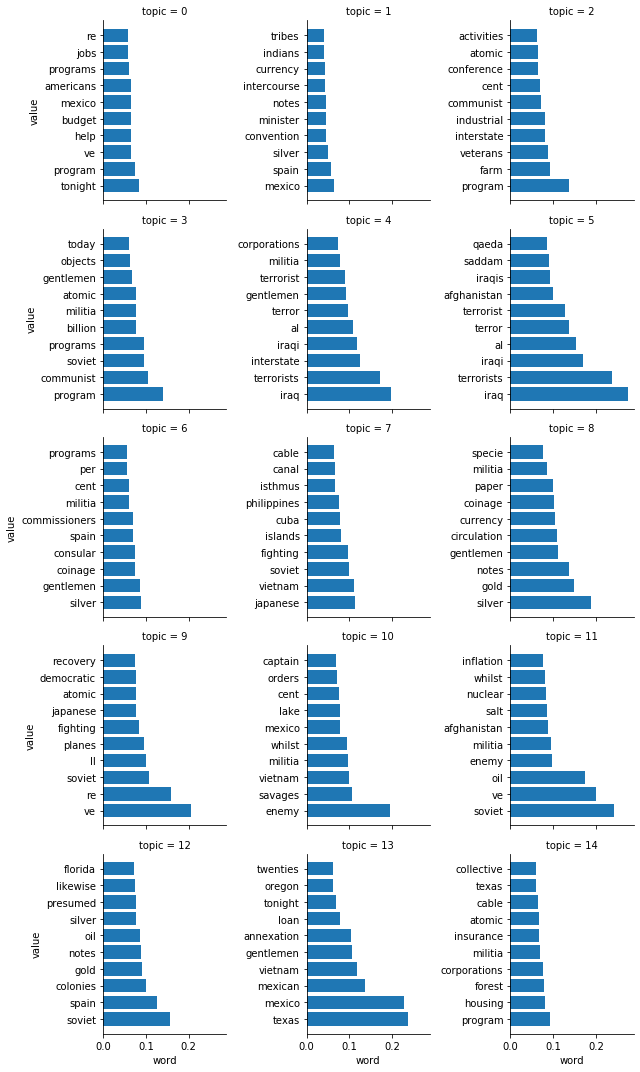

In [102]:
import seaborn as sns

g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

## Using LDA with Gensim

Now we'll use LDA.

In [114]:
from gensim.utils import simple_preprocess

texts = df.content.apply(simple_preprocess)

In [115]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)
corpus = [dictionary.doc2bow(text) for text in texts]

In [116]:
from gensim import models

n_topics = 15

lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics)

In [117]:
lda_model.print_topics()

[(0,
  '0.003*"1260" + 0.003*"1930" + 0.003*"1971" + 0.003*"1559" + 0.003*"1327" + 0.002*"151" + 0.002*"1986" + 0.002*"1446" + 0.002*"951" + 0.002*"266"'),
 (1,
  '0.003*"1626" + 0.003*"1986" + 0.003*"1559" + 0.003*"1784" + 0.002*"976" + 0.002*"440" + 0.002*"1257" + 0.002*"1060" + 0.002*"951" + 0.002*"151"'),
 (2,
  '0.004*"1986" + 0.003*"1242" + 0.003*"1971" + 0.003*"1260" + 0.003*"1626" + 0.003*"1989" + 0.002*"62" + 0.002*"151" + 0.002*"1974" + 0.002*"1545"'),
 (3,
  '0.005*"1559" + 0.002*"1626" + 0.002*"951" + 0.002*"1446" + 0.002*"578" + 0.002*"1327" + 0.002*"1459" + 0.002*"973" + 0.002*"976" + 0.002*"1865"'),
 (4,
  '0.005*"1260" + 0.005*"1930" + 0.004*"1999" + 0.003*"1971" + 0.003*"1242" + 0.003*"1559" + 0.003*"1974" + 0.003*"1986" + 0.002*"1651" + 0.002*"1644"'),
 (5,
  '0.004*"1559" + 0.004*"1986" + 0.004*"1242" + 0.003*"1930" + 0.003*"1260" + 0.003*"1974" + 0.003*"1989" + 0.003*"1971" + 0.002*"440" + 0.002*"1964"'),
 (6,
  '0.006*"1559" + 0.003*"151" + 0.003*"1327" + 0.003*"97

In [118]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.012095 -0.001333       1        1  20.778040
12    -0.010225 -0.002192       2        1  16.692394
14     0.012752 -0.002009       3        1  13.141767
1     -0.006476  0.004056       4        1  11.298836
7      0.005682  0.004394       5        1   7.063231
4      0.010963 -0.002876       6        1   6.889607
3     -0.007298 -0.000966       7        1   6.375881
5      0.001685  0.003735       8        1   4.540204
10     0.003473  0.003148       9        1   2.914685
8      0.000313 -0.004656      10        1   2.446382
0     -0.000236 -0.002310      11        1   2.039492
2     -0.000400  0.002581      12        1   2.003813
13     0.000793 -0.000971      13        1   1.718387
11    -0.002597 -0.000089      14        1   1.471947
9      0.003665 -0.000514      15        1   0.625335, topic_info=     Category         Freq       Term        Total  loglift  logprob
1930  Default   701.000000       help   701.000000  30.0000  30.0000
1260  Default   693.000000  americans   693.000000  29.0000  29.0000
1986  Default   698.000000    program   698.000000  28.0000  28.0000
1242  Default   525.000000    million   525.000000  27.0000  27.0000
1559  Default  1084.000000     mexico  1084.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
578   Topic15     2.689544  estimated   429.737518   0.0008  -6.4090
1986  Topic15     3.084783    program   698.228394  -0.3474  -6.2719
976   Topic15     2.868073      spain   553.003967  -0.1871  -6.3447
1999  Topic15     2.704442    tonight   455.161865  -0.0511  -6.4034
1922  Topic15     2.515182   problems   369.007599   0.0862  -6.4760

[1025 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
811       1  0.221521  abuses
811       2  0.119991  abuses
811       3  0.083070  abuses
811       4  0.110760  abuses
811       5  0.101530  abuses
...     ...       ...     ...
990      11  0.021744    york
990      12  0.014496    york
990      13  0.021744    york
990      14  0.014496    york
990      15  0.007248    york

[7654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 13, 15, 2, 8, 5, 4, 6, 11, 9, 1, 3, 14, 12, 10])